# RNA-Seq Analysis Training Demo

## Overview

This tutorial will show you the following workflow that is used to generate the list of differentially expressed genes. Running the code in this tutorial should take approximately 15 minutes.

This overflow centers roughly around the useage of the deseq2 package. Documentation for this package can be found here: https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html

![RNA-Seq workflow](images/count-workflow.png)

### STEP 1: Library Installation

First install the R packages that will be used. <strong>This installation may take around 15 minutes.</strong>

In [2]:
###install the libraries first, if required
install.packages("BiocManager")

if (!require("ComplexHeatmap"))
    BiocManager::install("ComplexHeatmap")

if (!require("DESeq2"))
    ##There is sometimes an error caused by libxml2 in /opt/conda/bin/
    ##being possibly a different version than in /usr/bin
    ##this causes an error about headers mismatching during deseq2 installation.
    ##there are different ways to address this, but here we just hide the
    ## /opt/conda/bin/ directory temporarily to avoid this error.
    hide_conda_bin <- "import os
os.environ['PATH'] = '/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games'"
    reticulate::py_run_string(hide_conda_bin)
    BiocManager::install("DESeq2")
    unhide_conda_bin <- "import os
os.environ['PATH'] = '/opt/conda/bin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games'"
    reticulate::py_run_string(unhide_conda_bin)
if (!require("EnhancedVolcano"))
    BiocManager::install('EnhancedVolcano')

if (!require("dplyr"))
    install.packages("dplyr")

if (!require("pheatmap"))
    install.packages("pheatmap")

if (!require("ggrepel"))
    install.packages("ggrepel")

if (!require("ggfortify"))
    install.packages("ggfortify")


###load the libraries
library(DESeq2)
library(dplyr)
library(ComplexHeatmap)
library(EnhancedVolcano)
library(ggplot2)
library(ggrepel)
library(ggfortify)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Loading required package: ComplexHeatmap

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: DESeq2

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘DESeq2’”
'getOpt

### STEP 2: Reading in Data

Next read-in the gene count data that will be analyzed.

This read-in step often involves reformatting or adjusting the data.

To make things easier, we created a matrix, or a table, of just our read-count data -- excluding the non-numerical metadata columns. This makes it easy for us to feed this table into the deseq2 tool later on.

Additionally, later on we will use normalization involving logarithms. So, to prevent errors, we will replace all readcount values of '0' in our data, with '1'. This will change the data only slightly, and will prevent these zeroes from causing an 'undefined' or 'N/A' math error in the logarithm normalization step.


In [3]:
#download genecounts and annotation file from cloud storage bucket
system("mkdir -p data/gene_counts", intern=TRUE)
system("mkdir -p data/reference", intern=TRUE)
system("gsutil cp gs://rnaseq-myco-bucket/salmon/SRP300216_merged_quants.txt data/gene_counts/SRP300216_genecounts.txt")
#download feature table to use for joining annotations later
system("gsutil cp gs://rnaseq-myco-bucket/reference/GCF_001632805.1_ASM163280v1_feature_table.txt data/reference/GCF_001632805.1_ASM163280v1_feature_table.txt", intern=TRUE)

character(0)

character(0)

character(0)

In [4]:
#read-in the raw gene count file to a dataframe variable we named 'read_counts'
read_counts <- read.table('data/gene_counts/SRP300216_genecounts.txt',head=TRUE)

#amount of columns the dataframe has
cols = ncol(read_counts)

#assign the numerical read counts to a matrix variable we named 'rnaseqMatrix'
rnaseqMatrix <- round(read_counts[,c(2:cols)])

#label the rownames of this matrix with the rowname column from the gene count dataframe.
rownames(rnaseqMatrix) <- read_counts[,1]

head(rnaseqMatrix)


,GSM5004088,GSM5004089,GSM5004090,GSM5004091,GSM5004092,GSM5004093
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BB28_RS24845,118,94,105,45,36,46
BB28_RS24840,308,296,288,101,81,137
BB28_RS24300,1020,834,931,352,259,405
BB28_RS24270,3,4,0,1,0,3
BB28_RS24265,26,14,17,5,6,9
BB28_RS24255,19,21,16,29,30,56


### STEP 3: Specifying Experimental Design

Next specify the experimental design. 

The deseq2 tool will later use this design to group samples together, and output information about the statistical differences in gene expression between these specified groups.

In [5]:
# define the sample experimental design, in this case 3 wildtype and 3 bacteriophage infected samples
samples_treatment <- data.frame(matrix(c(rep("WT",3),rep("BPs_lysogen",3)),ncol=1))
samples_ID <- data.frame(matrix(colnames(rnaseqMatrix),ncol=1))
samples <- cbind(samples_ID,samples_treatment)
names(samples) <- c("ID","Treatment")
rownames(samples) <- samples[,1]

print("An example of how a deseq2 experimental design table might look.")
samples



[1] "An example of how a deseq2 experimental design table might look."


,ID,Treatment
,<chr>,<chr>
GSM5004088,GSM5004088,WT
GSM5004089,GSM5004089,WT
GSM5004090,GSM5004090,WT
GSM5004091,GSM5004091,BPs_lysogen
GSM5004092,GSM5004092,BPs_lysogen
GSM5004093,GSM5004093,BPs_lysogen


### STEP 4: Creating Deseq2 Object

Now use the treatment design matrix in combination with the readcount matrix to create a deseq2 object. 

Once created, this is also a good opportunity to filter out lowly expresseed genes, and to inspect the pre-normalized data using pairwise comparison plots. These example plots, the pairwise plot and boxplot, can be used to examine gene expression distributions and highlight outliers.

Finally, the deseq2 analysis can be run on the deseq2 object.

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


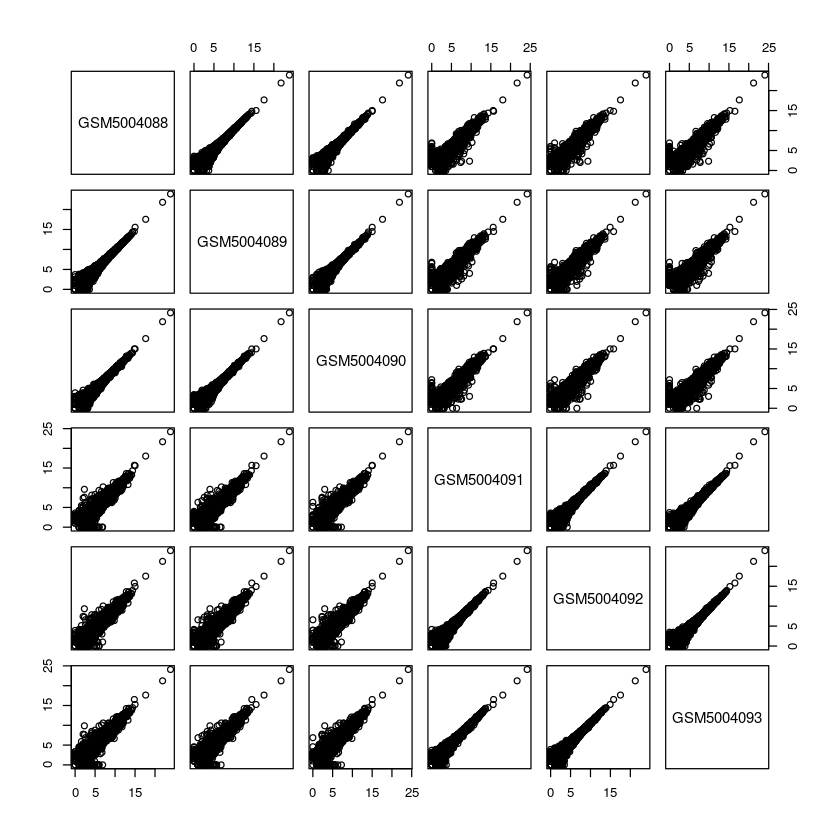

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



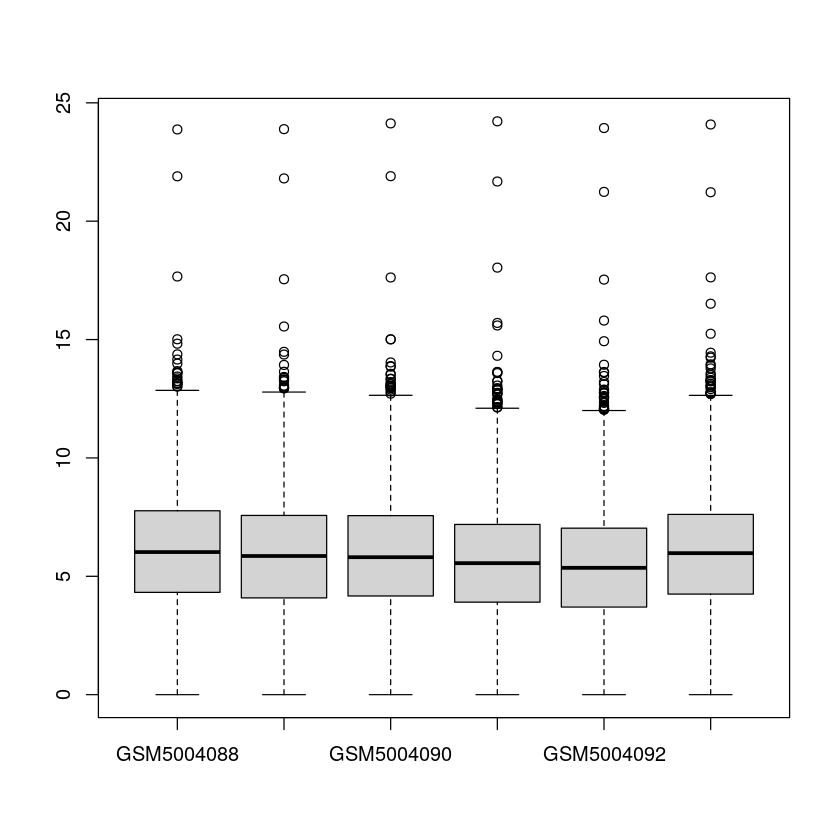

In [6]:
#Create the DEseq2DataSet object
deseq2Data <- DESeqDataSetFromMatrix(countData = rnaseqMatrix, colData = samples, design = ~ Treatment)

# Perform pre-filtering of the data (deseq2 also automatically does this, but can this can increase speed)
deseq2Data <- deseq2Data[rowSums(counts(deseq2Data)) > 10, ]

# Inspect pre-normalized data 
pairs(log2((counts(deseq2Data)+1)))
boxplot(log2((counts(deseq2Data)+1)))

# Run pipeline for differential expression steps
deseq2Data <- DESeq(deseq2Data)


### STEP 5: Normalize Data

DESeq2 automatically normalizes data in the DESeq() step using a method called median of ratios. For our own downstream analysis we can pick from several different normalization methods. As an example, here we use rlog transformation, or regularized log transformation to normalize data. This method is similar to log normalization, but includes a 'shrinkage' estimator to attempt to shrink the variance of the log-transformed data. More information for this and other normalization methods can be found in the DESeq2 documentation. 

Normalization of gene readcounts across samples will help to minimize sample variation noise and ensure more accurate comparisons. Looking at normalized plots can be an easy way to look out for any obvious inconsistencies or errors in the sample data. 

In [7]:
#perform rlog normalization on deseq2 object
rld <- rlog(deseq2Data, blind=FALSE)

#a handy variable so we can easily reference the rlog genecount matrix in the future, as deseq objects contain many tables of data.
rlogcounts <- assay(rld)
rownames(rlogcounts) <- rownames(deseq2Data)

head(rlogcounts)

,GSM5004088,GSM5004089,GSM5004090,GSM5004091,GSM5004092,GSM5004093
BB28_RS24845,6.4097497,6.3184522,6.4248340,5.8591462,5.7894407,5.6517859
BB28_RS24840,7.8662624,7.9802134,7.9454474,7.0222765,6.9327428,7.0479614
BB28_RS24300,9.6229173,9.5410091,9.6794730,8.7312088,8.5130326,8.5679423
BB28_RS24270,0.7795705,0.8253392,0.6838981,0.7313994,0.6927364,0.7869511
BB28_RS24265,3.8139750,3.5930635,3.6707460,3.3762240,3.4465121,3.4336746
BB28_RS24255,4.4496337,4.5733255,4.4445161,4.8888634,4.9896759,5.1839448


Normalization of data can is often verified by inspecting by various plots, such as histograms (these typically follow a negative binomial distribution, as shown below):

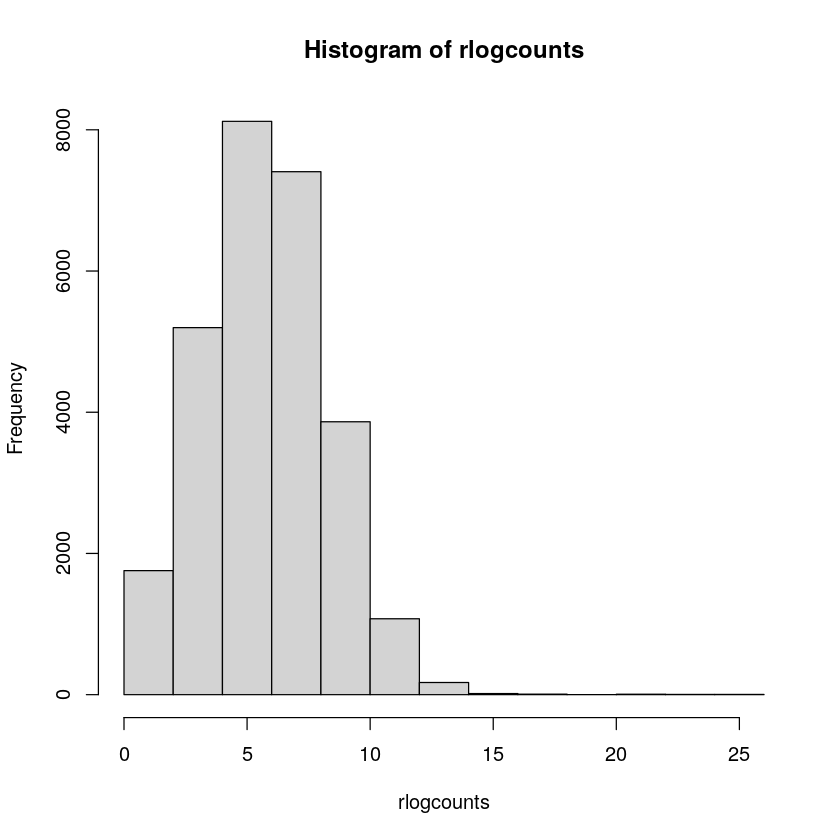

In [8]:
hist(rlogcounts)

Boxplots:

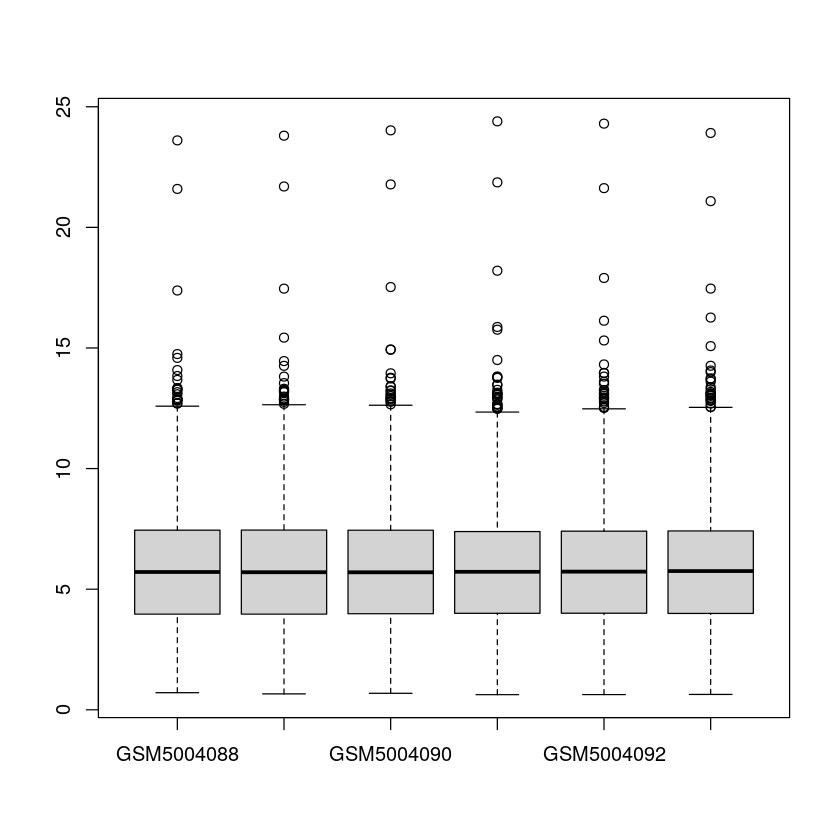

In [9]:
boxplot(rlogcounts)

Or pairwise comparison plots. Notice how sample groups can be visualized just by looking at the pairwise plot.

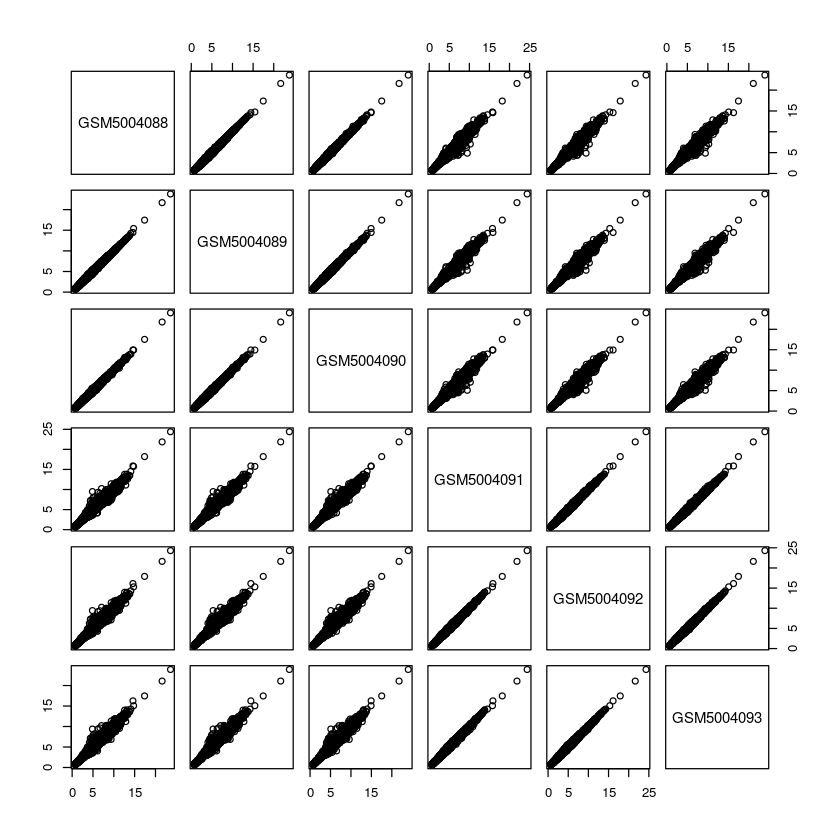

In [10]:
pairs(rlogcounts)

Compare the plots of the pre-normalized and normalized data to see the effect of normalization.

Notice how the samples in the box plot, and in-group samples in the pair plots display similar distributions.

Looking at normalized plots can be an easy way to look out for any obvious inconsistencies or errors in the sample data.

### STEP 6: PCA Plot

We can now begin to produce plots to further analyze the differences between groups.

PCA plots can be an effective way to visualize variation within and between sample sets.

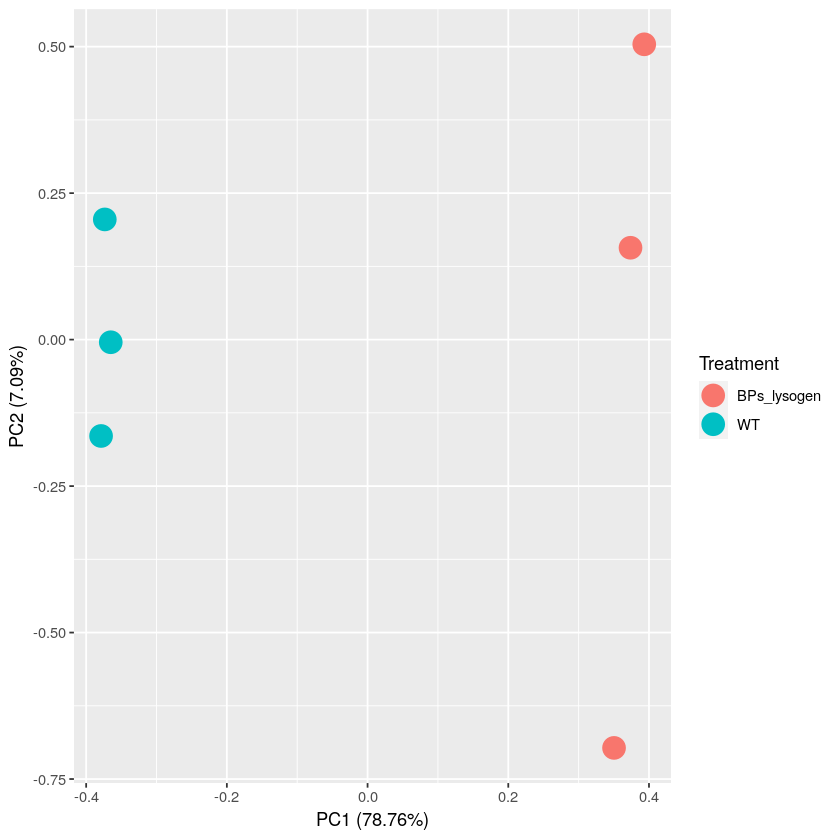

In [11]:
pca_counts <- prcomp(t(rlogcounts))
autoplot(pca_counts, data = samples, colour="Treatment", size=6)

Plots can be output as above, or also saved as pdf or image files, as below. Try to navigate and click to the created file, after you run the code. 

Tiff files can also be created this way.

In [12]:
pdf("data/gene_counts/PCA_Plot.pdf")
autoplot(pca_counts, data = samples, colour="Treatment", size=6)
dev.off()

tiff("data/gene_counts/PCA_Plot.tiff")
autoplot(pca_counts, data = samples, colour="Treatment", size=6)
dev.off()    

png 
  2

png 
  2

### STEP 7: Contrast Comparisons

Contrast comparisons between two treatment groups can be performed using the deseq2 tool to identify differentially up and down regulated genes.

Using R, these results can be summarized, reordered, and/or trimmed.

Differentially expressed genes are typically quantified as those genes which have an adjusted P value of below 0.05. An adjusted P value is also sometimes referred to as a false discovery rate, or FDR. In the below, there are 1357 differentially expressed genes. For the sake of reducing the amount of differentially expressed genes, to make analyses easier, these could also be further refined by introducing a threshold based on fold-change. DEseq2 uses the Wald and Benjamini-Hochberg tests for determining P and Adjusted P values, respectively. More information on this can be found in the DEseq2 documentation. 

In [13]:
#Output the results of comparing WT and BPs_lysogen group
res_WT_BPs <- results(deseq2Data, contrast=c("Treatment","WT","BPs_lysogen"))
summary(res_WT_BPs)
print("Number of genes under a p value of 0.05")
sum(res_WT_BPs$pvalue < 0.05, na.rm=TRUE)
print("Number of genes under a p adjusted value of 0.05")
sum(res_WT_BPs$padj < 0.05, na.rm=TRUE)


#deseq2 optionally output some padj values as 'NA' when genecounts meet certain criteria
#that criteria can be found here: https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pvaluesNA
#for practical uses, one could replace the NA values with '1', essentially NA values not significant.
res_WT_BPs$padj[is.na(res_WT_BPs$padj)] <- 1


out of 4605 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 819, 18%
LFC < 0 (down)     : 813, 18%
outliers [1]       : 0, 0%
low counts [2]     : 179, 3.9%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "Number of genes under a p value of 0.05"


[1] 1763

[1] "Number of genes under a p adjusted value of 0.05"


[1] 1357

### STEP 8: Annotating and Exporting Results

These differentially expressed genes can be annotated and exported.

Combining gene counts with gene annotation isn't always simple, and will vary heavily depending on the annotation file itself.

For example, when merging genecounts by 'gene id' with feature tables from NCBI's assembly database, its very common to have duplicate rows, as a single 'gene id' may match to multiple features. 

Depending on how you want to use your annotated results, you may decide to further reformat your table in whatever suits your further analysis best, for instance by downloading and using a spreadsheet editor.

Because the transcript table for m chelonae we have here is so simple, and contains essentially only one 'CDS' or '..RNA' feature for every gene identifier we are using, it is easy for us to reformat it here in the way we want just using R code. However, it is important to note that, again, this is very often not the case, and reformatting will vary depending on both the annotation file itself, and what that annotation file will be used for.

In [14]:
#read-in the annotation file (see extended tutorial for more info on how to get annotation files) and store it into a variable.
annotation <- read.table("data/reference/GCF_001632805.1_ASM163280v1_feature_table.txt", header=TRUE,sep='\t', quote="\"",comment.char = "")

#put the previous deseq results into an easier to manipulate data.frame format
results <- data.frame(res_WT_BPs)

#merge the annotation with the deseq2 contrast comparison table
results.annot <- merge(results,annotation,by.x=0,by.y=17,all.x=TRUE)



#Open the annotation file above to see the format. If you further download and examine in a spreadsheet editor,
#you can see there is one CDS or ..RNA identifier for each 'gene' feature
#this makes reformatting in R simple by just removing every 'gene' feature, and leaving the more detailed 'cds' or '...RNA' feature.
#this is very often not always the case, but simple and easy here.
results.annot <- results.annot[annotation$X..feature!='gene',]

#labeling the columns properly after the merge
colnames(results.annot)[1] <- 'locus_tag'

#write out the file
write.table(results.annot,"data/gene_counts/WT_BPs_DESeq2_annot.txt",row.names=FALSE,sep="\t")

head(results.annot)


,locus_tag,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,X..feature,class,assembly,⋯,strand,product_accession,non.redundant_refseq,related_accession,name,symbol,GeneID,feature_interval_length,product_length,attributes
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<int>,<int>,<int>,<chr>
2,BB28_RS00005,465.5947,0.66733104,0.1158310,5.761246,8.349511e-09,1.017006e-07,gene,protein_coding,GCF_001632805.1,⋯,+,,,NA,,dnaA,31677580,1476,NA,old_locus_tag=BB28_00005
4,BB28_RS00010,312.4363,0.25993860,0.1280622,2.029784,4.237853e-02,1.115808e-01,gene,protein_coding,GCF_001632805.1,⋯,+,,,NA,,dnaN,31677581,1200,NA,old_locus_tag=BB28_00010
6,BB28_RS00015,340.6501,0.57232028,0.1326868,4.313317,1.608232e-05,1.120950e-04,CDS,with_protein,GCF_001632805.1,⋯,+,WP_046251966.1,WP_046251966.1,NA,decarboxylating 6-phosphogluconate dehydrogenase,gnd,31677582,894,297,
8,BB28_RS00020,100.3025,0.89863440,0.1982573,4.532668,5.824337e-06,4.452248e-05,gene,protein_coding,GCF_001632805.1,⋯,+,,,NA,,recF,31677583,1149,NA,old_locus_tag=BB28_00020
10,BB28_RS00025,113.1915,0.50491799,0.1930194,2.615892,8.899472e-03,3.181669e-02,gene,protein_coding,GCF_001632805.1,⋯,+,,,NA,,,31677584,552,NA,old_locus_tag=BB28_00025
12,BB28_RS00030,3311.5852,-0.09956595,0.0852011,-1.168599,2.425651e-01,4.116538e-01,CDS,with_protein,GCF_001632805.1,⋯,+,WP_046251970.1,WP_046251970.1,NA,DNA topoisomerase (ATP-hydrolyzing) subunit B,gyrB,31677585,2028,675,


### STEP 9: More Plots and Clustering Data

Finally, although several other different kind of analysis can be done, it is common to plot the results of differential gene expression analysis in forms such as volcano, MA, and heatmaps. These plots help one to further examine the output list of differentially expressed genes in different ways, and potentially identify or further investigate candidate gene(s).

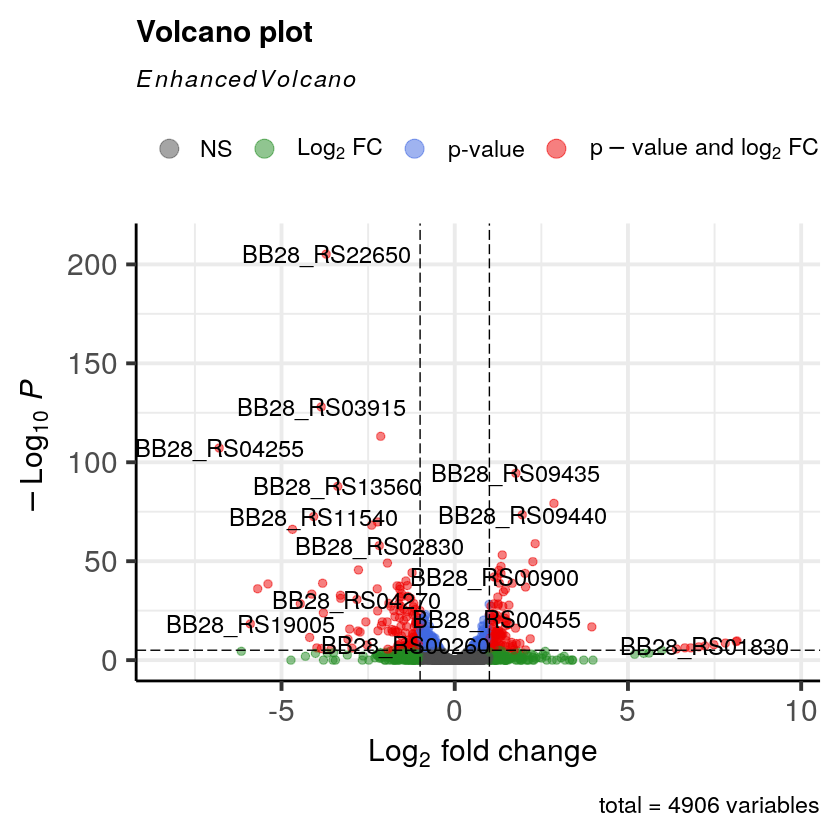

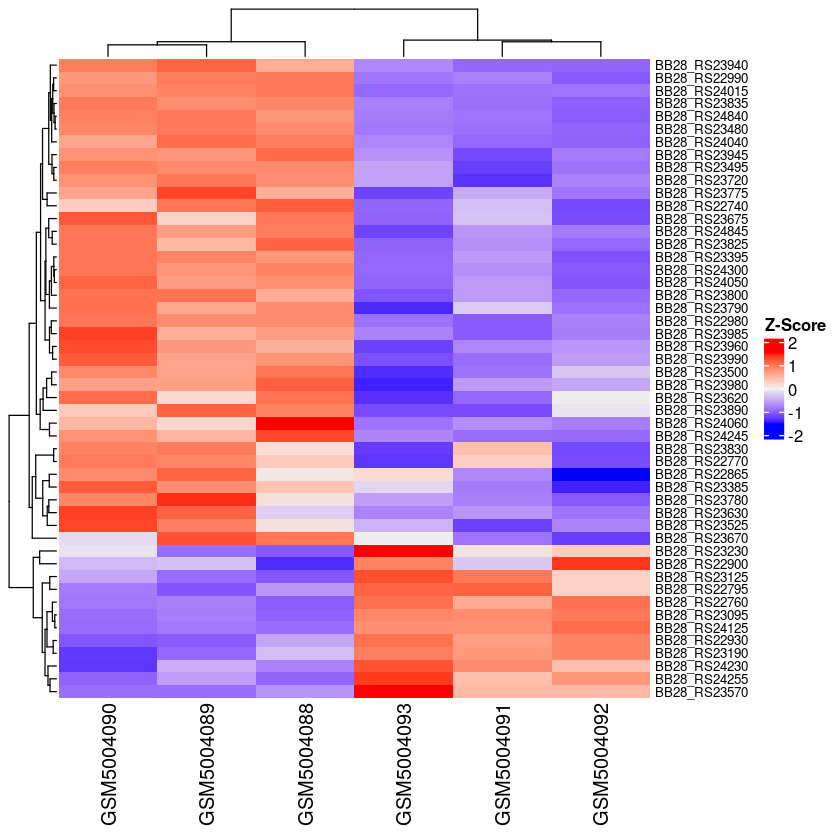

In [15]:
#volcano and ma plots can be used to visualize significant differences in gene expression
results_volc_df <- results.annot
EnhancedVolcano(results_volc_df,
    lab = results_volc_df[,1],
    x = 'log2FoldChange',
    y = 'padj')

#ma plot
plotMA(res_WT_BPs)


#heatmaps can used to look at clustering and expression of various gene lists.
filtered_res <- results.annot %>% filter(padj < 0.05)
filtered_res_counts <- subset(rlogcounts, rownames(rlogcounts) %in% filtered_res[,1])
filtered_res_counts = t(scale(t(filtered_res_counts)))
Heatmap(filtered_res_counts[1:50,], name = "Z-Score", row_names_gp = gpar(fontsize = 8))

## <a name="workflow">Additional Workflows</a>

Now that you have ran some analysis on read count data, feel feel free to explore and revisit the previous workflows for creating readcounts, such as the standard or extended tutorials, or the snakemake tutorial.


[Workflow One:](Tutorial_1.ipynb) A short introduction to downloading and mapping sequences to a transcriptome using Trimmomatic and Salmon. Here is a link to the YouTube video demonstrating the tutorial: <https://youtu.be/ChGfBR4do_Y>.

[Workflow One (Extended):](Tutorial_1B_Extended.ipynb) An extended version of workflow one. Once you have got your feet wet, you can retry workflow one with this extended version that covers the entire dataset, and includes elaboration such as using SRA tools for sequence downloading, and examples of running batches of fastq files through the pipeline. This workflow may take around an hour to run.

[Workflow One (Using Snakemake):](Tutorial_2_Snakemake.ipynb) Using snakemake to run workflow one.

[Workflow Two (DEG Analysis):](Tutorial_3_DEG_Analysis.ipynb) Using Deseq2 and R to conduct clustering and differential gene expression analysis.


![RNA-Seq workflow](images/RNA-Seq_Notebook_Homepage.png)